In [1]:
import sys
import os
import pandas as pd

current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"La root del progetto è: {project_root}")

La root del progetto è: c:\Users\David\Desktop\studio\bayes_naive\sms_spam


In [ ]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from app.utils.preprocessor import TextPreprocessor

import matplotlib.pyplot as plt

import joblib


In [3]:
SMSSpam = pd.read_csv('./dati/SMSSpamCollection.csv')
SMSSpam.columns = ['text']
SMSSpam

,text
0,ham\tOk lar... Joking wif u oni...
1,spam\tFree entry in 2 a wkly comp to win FA Cu...
2,ham\tU dun say so early hor... U c already the...
3,"ham\tNah I don't think he goes to usf, he live..."
4,spam\tFreeMsg Hey there darling it's been 3 we...
...,...
5568,spam\tThis is the 2nd time we have tried 2 con...
5569,ham\tWill ü b going to esplanade fr home?
5570,"ham\tPity, * was in mood for that. So...any ot..."
5571,ham\tThe guy did some bitching but I acted lik...


vado a splittare la colonna text in 2 colonne

In [4]:
nuovi_nomi_colonne = ['label', 'message']

SMSSpam[nuovi_nomi_colonne] = SMSSpam['text'].str.split('\t', expand=True)
SMSSpam = SMSSpam.drop(columns=['text'])

SMSSpam

,label,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
...,...,...
5568,spam,This is the 2nd time we have tried 2 contact u...
5569,ham,Will ü b going to esplanade fr home?
5570,ham,"Pity, * was in mood for that. So...any other s..."
5571,ham,The guy did some bitching but I acted like i'd...


suddivido il mio dataset in X e y

In [5]:
X = SMSSpam['message']
y = SMSSpam['label'].map({'ham': 0, 'spam': 1})

In [6]:
X

0                           Ok lar... Joking wif u oni...
1       Free entry in 2 a wkly comp to win FA Cup fina...
2       U dun say so early hor... U c already then say...
3       Nah I don't think he goes to usf, he lives aro...
4       FreeMsg Hey there darling it's been 3 week's n...
                              ...                        
5568    This is the 2nd time we have tried 2 contact u...
5569                 Will ü b going to esplanade fr home?
5570    Pity, * was in mood for that. So...any other s...
5571    The guy did some bitching but I acted like i'd...
5572                           Rofl. Its true to its name
Name: message, Length: 5573, dtype: object

In [7]:
print('classi ham: ',y[y == 0].count())
print('classi spam', y[y == 1].count())
tradeoff = y[y == 0].count() / y[y == 1].count()
print('tradeoff ham/spam: ', tradeoff)

classi ham:  4826
classi spam 747
tradeoff ham/spam:  6.460508701472557


le classi ham sono 6 volte in piu delle classi spam, implementerò un meccanismo di oversampling

In [8]:
stop_words_list = 'english' 

pipeline = Pipeline(steps=[
    ('pulizia_punteggiatura', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(stop_words=stop_words_list)),
    ('nb', MultinomialNB())
])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [10]:
y_train

4651    1
984     0
3895    0
4012    0
1670    0
       ..
4833    1
2324    0
2587    0
3       0
2454    0
Name: label, Length: 4458, dtype: int64

In [11]:
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1,3)],
    'tfidf__max_features': [5000, 10000, None],
    'nb__alpha': [0.1, 0.25, 0.5, 0.75, 1.0]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)



In [12]:
grid_search.fit(X_train, y_train)

print("Migliori parametri trovati:", grid_search.best_params_)
print("Miglior F1-Score (media CV):", grid_search.best_score_)

Migliori parametri trovati: {'nb__alpha': 0.1, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}
Miglior F1-Score (media CV): 0.9398690939314154


In [13]:
bp = grid_search.best_params_

bp

{'nb__alpha': 0.1, 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}

In [14]:
X_train_pred = grid_search.best_estimator_.predict(X_train)
X_test_pred = grid_search.best_estimator_.predict(X_test)


In [15]:
def evaluate_predictions(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (ham)', 'Classe 1 (spam)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    

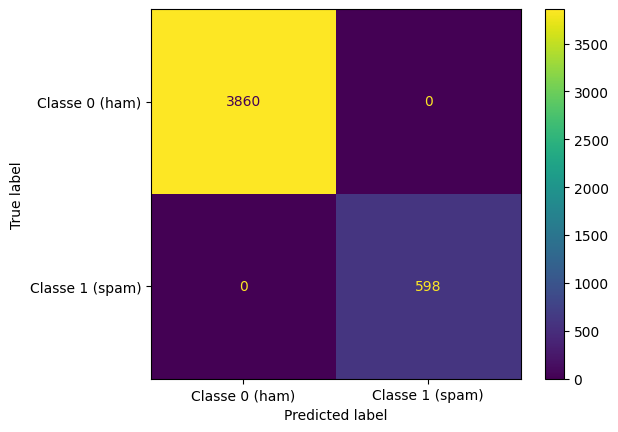

                 precision    recall  f1-score   support

 Classe 0 (ham)       1.00      1.00      1.00      3860
Classe 1 (spam)       1.00      1.00      1.00       598

       accuracy                           1.00      4458
      macro avg       1.00      1.00      1.00      4458
   weighted avg       1.00      1.00      1.00      4458

[[3860    0]
 [   0  598]]


In [16]:
evaluate_predictions(X_train_pred, y_train)

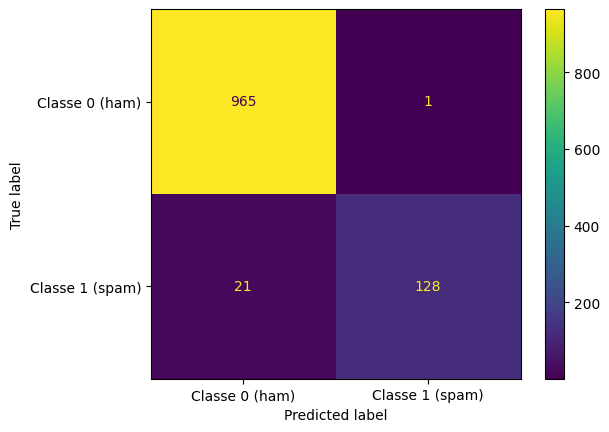

                 precision    recall  f1-score   support

 Classe 0 (ham)       0.98      1.00      0.99       966
Classe 1 (spam)       0.99      0.86      0.92       149

       accuracy                           0.98      1115
      macro avg       0.99      0.93      0.95      1115
   weighted avg       0.98      0.98      0.98      1115

[[965   1]
 [ 21 128]]


In [17]:
evaluate_predictions(X_test_pred, y_test)

In [18]:
joblib.dump(grid_search.best_estimator_, '../sms_spam_pipeline.joblib')
print("Pipeline salvata come 'sms_spam_pipeline.joblib'")

Pipeline salvata come 'sms_spam_pipeline.joblib'
